# Desafio 03 - Problema das etiquetas

O problema foi quebrado em 3 passos:

1.   Identificação das etiquetas com Yolo
2.   Identificação da area de interesse dentro da etiqueta com EAST
3.   Identificação do texto com Tesseract


## 1. Identificação das etiquetas com Yolo

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/TensorFlow-2.x-YOLOv3
!ls
!pip install -r ./requirements.txt

/content/gdrive/.shortcut-targets-by-id/1vMn5_0wt-zDS-7ox2h3-zrbSGv4f7v1U/TensorFlow-2.x-YOLOv3
 challeng-03-labels.ipynb
 checkpoints
'Cópia de teste_pesos_etiq.ipynb'
'Cópia de yolov3_custom.data-00000-of-00001'
'Cópia de yolov3_custom.index'
 custom_dataset
 custom_dataset_plate
 deep_sort
 detection_custom.py
 detection_demo.py
 detect_mnist.py
 evaluate_mAP.py
 IMAGES
 LICENSE
 log
 mAP
 mnist
 model_data
 object_tracker.py
 __pycache__
 README.md
 requirements.gdoc
 requirements.txt
 teste_pesos_etiq.ipynb
 tools
 train.py
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled.ipynb
 yolov3
 YOLOv3_colab_training.ipynb
 yolov3_custom.data-00000-of-00001
 yolov3_custom.index


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

from yolov3.yolov4 import Create_Yolo
from yolov3.utils import load_yolo_weights, detect_image
from yolov3.configs import *
from yolov3.utils2 import detectar_imagem

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

Usando transfer learning com um treino customizado para identificação de etiquetas.

In [ ]:
yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE, CLASSES=TRAIN_CLASSES)
yolo.load_weights("./checkpoints/yolov3_custom")

Exemplo de identificação:

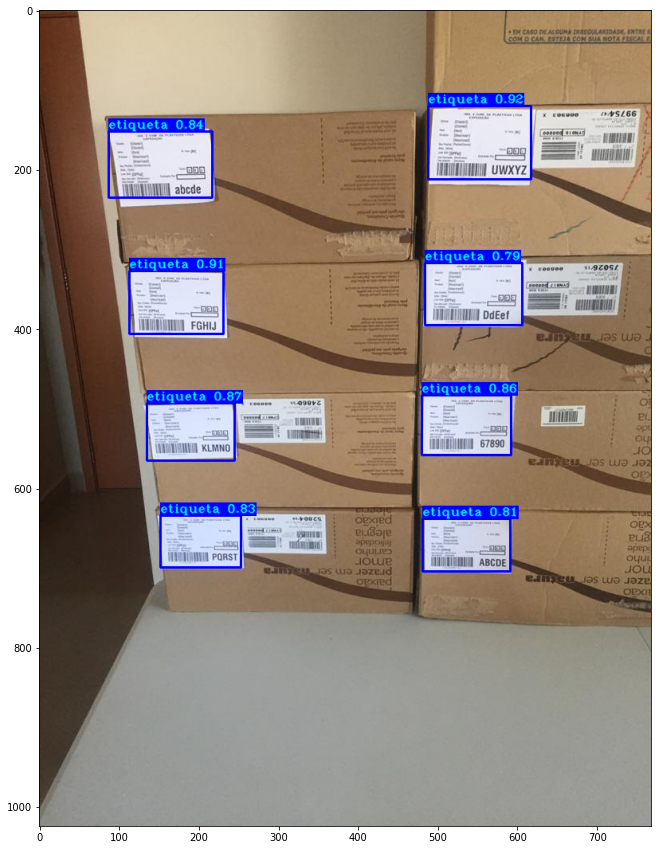

In [ ]:
caminho = "./custom_dataset/test/10.jpeg"
image = cv2.imread(caminho)

image_detected, boxes = detectar_imagem(yolo, caminho, "", input_size=YOLO_INPUT_SIZE, show=False, CLASSES=TRAIN_CLASSES, rectangle_colors=(255,0,0))
image_detected = cv2.cvtColor(image_detected, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,15))
plt.imshow(image_detected)

Recortar etiquetas

In [ ]:
def area_interesse(boxes, image):
  images = []
  
  for i in range(len(boxes)):
    startX = int(boxes[i][0]) 
    startY = int(boxes[i][1]) 
    endX = int(boxes[i][2]) 
    endY = int(boxes[i][3])

    crop = image[startY:endY, startX:endX]
    images.append(crop)

  return images

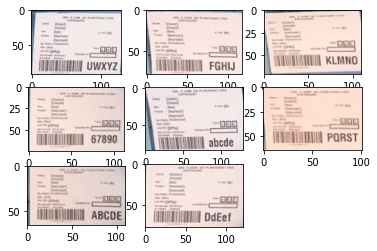

In [94]:
images = area_interesse(boxes, image)

for i in range(len(images)):
	plt.subplot(330 + 1 + i)
	plt.imshow(images[i])
plt.show()

## 2. Identificação da area de interesse dentro da etiqueta com EAST

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,944 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

Instalando o pytesseract.

Agora que temos todas as etiquetas recortadas, iremos identificar a região em que está o código que queremos ler.

In [ ]:
from imutils.object_detection import non_max_suppression
import pytesseract

Aqui no caso, se estamos utilizando uma lista com as fotos das varias etiquetas, entao nao precisamos de "image" com o endereco.

Basta entao so usar o n-ésimo elemento da lista (lis[n]) ao inves do imread.

In [ ]:
args = {"east":"/content/gdrive/My Drive/frozen_east_text_detection.pb", "min_confidence":0.4}

Vamos carregar a rede e definir camadas.

In [ ]:
net = cv2.dnn.readNet(args["east"])

layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

Basicamente essa funcao percorre as regioes dadas em geometria, observa se estao acima do score necessario, caso sim obtem suas coordenadas

In [ ]:
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# itera sobre as linhas
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# itera sobre o numero de colunas
		for i in range(0, numC):
			if scoresData[i] < args["min_confidence"]:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extrai o angulo de rotacao para predizer e computar seno e cosseno
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# usando o volume geometrico para obter as dimensoes do retangulo
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# computar o comeco e o fim do retangulo de predicao
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# retorna os retangulos e os valores associados de probabilidade de acerto
	return (boxes, confidence_val)

Vamos preparar as imagens para o EAST.

In [84]:
def regiao_codigo(outro):
  
  #Faz uma copia da imagem original
  orig = outro.copy()
  (origH, origW) = outro.shape[:2]

  #Essas sao as dimensoes da imagem a ser passada para o EAST  
  (newW, newH) = (960, 640)

  #Calcula a proporcao entre a imagem original e a nova que sera passada para o EAST 
  #Essa proporcao sera usada para transferir os retangulos para a imagem original 
  rW = origW / float(newW)
  rH = origH / float(newH)

  #Redimensiono a imagem para passa-la ao EAST
  outro = cv2.resize(outro, (newW, newH))
  (H, W) = outro.shape[:2]

  blob = cv2.dnn.blobFromImage(outro, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
  
  net.setInput(blob)
  (scores, geometry) = net.forward(layerNames)

  (boxes2, confidence_val) = predictions(scores, geometry)
  boxes2 = non_max_suppression(np.array(boxes2), probs=confidence_val)

  return boxes2, orig, rW, rH

## 4. Identificação do texto com Tesseract

In [77]:
def achar_string(boxes2, orig, rW, rH):
  maior_janela = 0

  # itera sobre os retangulos para achar as melhores coordenadas
  for (startX, startY, endX, endY) in boxes2:
    # Alteramos um pouco os valores para que o codigo se encaixasse melhor nas imagens, assim evitando erros
    startX = int(startX * rW) 
    startY = int(startY * rH) 
    endX = int(endX * rW) 
    endY = int(endY * rH) 

    area = (endY - startY)*(endX - startX)

    (H, W) = orig.shape[:2]
    faixaH, faixaW= int((2 * H)/3), int((2 * W)/3)

    #verifica se essa é a maior janela possível (a maior é a que contém o código)
    if(area > maior_janela and endX > faixaW and endY > faixaH):
      maior_janela = area
      
      startX = startX + 5
      endX = endX + 5
      endY = endY + 5
      #extrai a regiao de interesse
      maior = orig[startY:endY, startX:endX]
      

  #configuracao para converter imagem para string  
  configuration = ("-l eng --oem 1 --psm 8")
  ##reconhecindo o texto de dentro do retangulo
  text = pytesseract.image_to_string(maior, config=configuration)

  return maior, text

WZ

wHIS

KLMING

67890

"| at

1 Pa

ABCDE

f | Dat



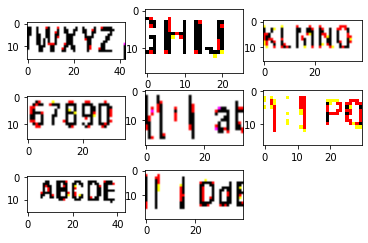

In [93]:
for i in range(len(images)):
  VALOR = 130
  thresh, im_tratada = cv2.threshold(images[i], VALOR, 255,cv2.THRESH_BINARY)
  boxes2, im, rW, rH = regiao_codigo(im_tratada)
  recorte, texto_recorte = achar_string(boxes2, im, rW, rH)
  
  c = plt.subplot(330 + 1 + i)
  c.imshow(recorte)
  print(texto_recorte)
 
plt.show()